In [1]:
%matplotlib inline

from IPython.display import display as d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
import glob
import json
import os
import sys
import json
import os
import sys
import multiprocessing
pool = multiprocessing.Pool(multiprocessing.cpu_count())

def plot(ax, figurename):
    os.makedirs("figures", exist_ok=True)
    ax.get_figure().savefig(f"figures/{figurename}.pdf", bbox="tight")
    ax.get_figure().savefig(f"figures/{figurename}.png", bbox="tight")



read and check the ratings file

In [2]:
df = pd.read_csv("ratings.csv")
df["video_name"] = df["video_name"].apply(
    lambda x: os.path.splitext(x.replace("['", "").replace("']", "").split("\\\\")[-1])[0]
)
d(df.head())

,rating,rating_type,timestamp,user_ID,video_ID,video_name
0,3,radio,2019-10-14 09:17:30 263829,1,0,BennuProRes4444.mov_1frame_crf_21_height_0320
1,4,radio,2019-10-14 09:17:40 502017,1,1,weapon8k-standard-60fps-12to1redcode_16x9_444....
2,2,radio,2019-10-14 09:17:53 471399,1,2,classroom.mkv_1frame_crf_18_height_0208
3,3,radio,2019-10-14 09:17:58 815831,1,3,NTIA_4K_Vignette_1_Violin-422p-8bit-60fps-4096...
4,4,radio,2019-10-14 09:18:04 565989,1,4,gooseberry.mkv_1frame_crf_08_height_0544


calculate mean opinion scores, ci values and check outlier (important, video_name := stimuli)

In [3]:
mos_per_videoname = df.groupby(by="video_name").mean().reset_index()[["video_name", "rating"]]
mos_per_videoname = mos_per_videoname.rename(columns={"rating": "mos"})
d(mos_per_videoname.head())

d_wo = pd.DataFrame()
no_out = 0
no_sub = 0
# simple outlier "detection", better use the ITU-Rec XYZ
for userid, group in df.groupby(by="user_ID"):
    no_sub += 1
    comp = pd.merge(group, mos_per_videoname, left_on="video_name", right_on="video_name")
    # calc correlation
    correlation_user_to_mos = comp[["rating", "mos"]].corr(method="pearson")["mos"][0]
    if correlation_user_to_mos < 0.8:
        print(f"outlier user {userid}")
        no_out += 1
    else:
        d_wo = d_wo.append(group, ignore_index=True)

print(f"out of {no_sub} : {no_out} outlier detected")
    
df = d_wo
# calculate final mos values
mos_per_videoname = df.groupby(by="video_name").mean().reset_index()[["video_name", "rating"]]
mos_per_videoname = mos_per_videoname.rename(columns={"rating": "mos"})
d(mos_per_videoname.head())

# calculate ci values
import scipy.stats as st

def confidence(x):
    x = x["rating"]
    y = st.t.interval(0.95, len(x) - 1, loc=np.mean(x), scale=st.sem(x))
    return  y[1] - y[0]


ci = d_wo[["video_name", "rating"]].groupby(by="video_name").apply(confidence).reset_index()
ci = ci.rename(columns={0: "ci"})

d(ci.head())

mos_ci_per_videoname = pd.merge(mos_per_videoname, ci, left_on="video_name", right_on="video_name")
mos_ci_per_videoname = mos_ci_per_videoname.rename(columns={"video_name": "image_name"})
d(mos_ci_per_videoname.head())
mos_ci_per_videoname.to_csv("mos_ci.csv", index=False)

,video_name,mos
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857


out of 21 : 0 outlier detected


,video_name,mos
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857


/home/stg7/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/stg7/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,video_name,ci
0,BennuProRes4444.mov_1frame_crf_03_height_0864,0.699565
1,BennuProRes4444.mov_1frame_crf_06_height_0592,0.568885
2,BennuProRes4444.mov_1frame_crf_08_height_0448,0.547677
3,BennuProRes4444.mov_1frame_crf_13_height_0304,0.547677
4,BennuProRes4444.mov_1frame_crf_21_height_0320,0.435249


,image_name,mos,ci
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249


perform SOS analysis (cf. [Hoßfeld et al: SOS: the mos is not enought](http://www.comnet.informatik.uni-wuerzburg.de/team/mitarbeiter/hossfeld/?tx_extbibsonomycsl_publicationlist%5BuserName%5D=uniwue_info3&tx_extbibsonomycsl_publicationlist%5BintraHash%5D=8151bc466638649fbec7ba55d8c97124&tx_extbibsonomycsl_publicationlist%5BfileName%5D=conf_422.pdf&tx_extbibsonomycsl_publicationlist%5Bcontroller%5D=Document&cHash=b602784dc7befe57424e55d7c5602199))

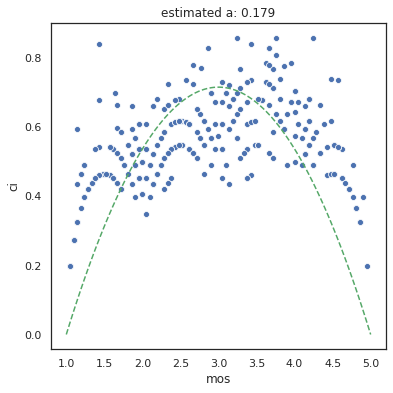

In [4]:
import seaborn as sns

sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")
# draw a SOS plot
# read: http://materials.dagstuhl.de/files/15/15022/15022.TobiasHo%C3%9Ffeld1.Preprint.pdf
# for a more detailed description of SOS plots

ax = sns.scatterplot(x="mos", y="ci", data=mos_ci_per_videoname)

#, with the y=(x-1)*(x-5)* a interpolated function 

x_data = mos_ci_per_videoname["mos"].values
y_data = mos_ci_per_videoname["ci"].replace(np.NaN, 0).values

from scipy.optimize import curve_fit

def fitting_function(x, a):
    return (x - 1) * (x - 5) * (-a)

popt, pcov = curve_fit(fitting_function, x_data, y_data) 


x = np.linspace(1, 5, 100)
ax.plot(x, fitting_function(x, *popt), 'g--')
ax.set_title(f"estimated a: {popt[0].round(3)}")

plot(ax, "sos")

parameter $a$ seems to be typical and ok for a image quality test, e.g. reported for IRCCyN/IVC Scores on
Toyama is around 0.17

next is to create the per user rating table

In [5]:
# create per user file
per_user = [] 
for i, g in df.groupby(by="video_name"):
    v = {
        "image_name": i,
        "mos": g["rating"].mean(),
        "ci": confidence(g)
    }
    for j, gg in g.groupby(by="user_ID"):
        user = "user" + str(j)
        v[user] = gg["rating"].values[0]
    per_user.append(v)

du = pd.DataFrame(per_user)
ucols = ["image_name"] + [x for x in du.columns if "user" in x] + ["mos", "ci"]
d(du[ucols].head())
du[ucols].to_csv("per_user.csv", index=False)

/home/stg7/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/stg7/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,image_name,user1,user2,user3,user4,user5,user6,user7,user8,user9,...,user14,user15,user16,user17,user18,user19,user20,user21,mos,ci
0,BennuProRes4444.mov_1frame_crf_03_height_0864,4,3,3,3,5,3,4,3,3,...,2,3,3,2,4,3,3,3,3.095238,0.699565
1,BennuProRes4444.mov_1frame_crf_06_height_0592,4,3,3,3,4,2,3,3,3,...,2,3,3,2,3,3,4,2,2.904762,0.568885
2,BennuProRes4444.mov_1frame_crf_08_height_0448,4,2,3,2,4,2,3,3,3,...,3,3,3,2,3,3,3,3,2.809524,0.547677
3,BennuProRes4444.mov_1frame_crf_13_height_0304,3,2,3,2,3,2,2,2,3,...,2,3,3,3,3,3,3,2,2.476190,0.547677
4,BennuProRes4444.mov_1frame_crf_21_height_0320,3,2,2,2,2,2,2,2,2,...,2,3,2,2,2,2,3,2,2.142857,0.435249


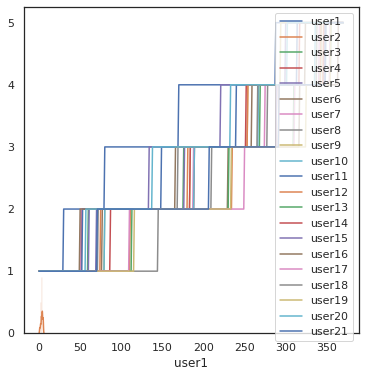

In [16]:

ax = None
for user in [x for x in du.columns if "user" in x]:
    ddd = du.sort_values(by=user).copy()
    ddd["c"] = range(len(ddd))
    ax = ddd.plot(x="c", y=user, ax=ax)
    ax.set_xlabel("stimuli")



In [36]:
da = pd.DataFrame()
for user in [x for x in du.columns if "user" in x]:
    #d(du[[user]])
    dd = du[[user]].copy()
    dd["rating"] = dd[user]
    dd["user"] = user
    dd = dd[["rating", "user"]]
    da = da.append(dd, ignore_index=True)
d(da.head())

,rating,user
0,4,user1
1,4,user1
2,4,user1
3,3,user1
4,3,user1


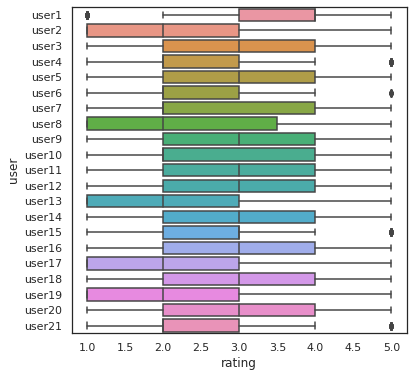

In [40]:
ax = sns.boxplot(y="user", x="rating", data=da)
plot(ax, "per_user")

create file for meta data

In [6]:
# meta data
du["crf"] = du["image_name"].apply(
    lambda x:
    int(x.split("_")[-3])
)
du["height"] = du["image_name"].apply(
    lambda x:
    int(x.split("_")[-1])
)
meta_cols = ["image_name", "crf", "height"]
d(du[meta_cols].head())
du[meta_cols].to_csv("meta.csv", index=False)

,image_name,crf,height
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3,864
1,BennuProRes4444.mov_1frame_crf_06_height_0592,6,592
2,BennuProRes4444.mov_1frame_crf_08_height_0448,8,448
3,BennuProRes4444.mov_1frame_crf_13_height_0304,13,304
4,BennuProRes4444.mov_1frame_crf_21_height_0320,21,320


combine objective metrics with subjective ratings

In [7]:
do = pd.read_csv("objective_metrics.csv")
d(do.head())
dr = pd.read_csv("mos_ci.csv")
d(dr.head())

dm = pd.merge(dr, do, left_on="image_name", right_on="image")
d(dm.head())
dm.to_csv("objective_metrics_and_mos_ci.csv", index=False)

,image,vmaf,adm2,psnr,ssim,ms_ssim,vif_scale0,vif_scale1,vif_scale2,vif_scale3
0,Netflix_PierSeaside_4096x2160_60fps_10bit_420....,28.79331,0.60176,28.65663,0.96732,0.88339,0.20083,0.39495,0.54165,0.71453
1,Netflix_PierSeaside_4096x2160_60fps_10bit_420....,71.93411,0.84915,33.29191,0.99617,0.96498,0.35968,0.75384,0.90116,0.96320
2,Netflix_PierSeaside_4096x2160_60fps_10bit_420....,54.94602,0.75518,30.99616,0.99173,0.93779,0.27757,0.58879,0.77411,0.90799
3,Netflix_PierSeaside_4096x2160_60fps_10bit_420....,4.30320,0.35872,25.02071,0.79255,0.72787,0.13101,0.21333,0.26497,0.32416
4,Netflix_PierSeaside_4096x2160_60fps_10bit_420....,31.56868,0.61176,28.88457,0.97646,0.89433,0.21185,0.42824,0.59093,0.77793


,image_name,mos,ci
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249


,image_name,mos,ci,image,vmaf,adm2,psnr,ssim,ms_ssim,vif_scale0,vif_scale1,vif_scale2,vif_scale3
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,BennuProRes4444.mov_1frame_crf_03_height_0864,96.55329,0.97798,55.46594,0.99986,0.99935,0.95478,0.99185,0.99633,0.99800
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,BennuProRes4444.mov_1frame_crf_06_height_0592,91.59939,0.95523,51.85869,0.99946,0.99832,0.90892,0.96960,0.98441,0.99114
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,BennuProRes4444.mov_1frame_crf_08_height_0448,86.01128,0.93306,49.23137,0.99851,0.99671,0.86305,0.93407,0.96006,0.97598
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,BennuProRes4444.mov_1frame_crf_13_height_0304,66.93424,0.86470,44.07120,0.99220,0.98897,0.74103,0.81244,0.85182,0.88802
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,BennuProRes4444.mov_1frame_crf_21_height_0320,52.66551,0.81816,40.36141,0.97856,0.97636,0.65859,0.71842,0.75014,0.77872


,image_name,mos,ci,image,vmaf,adm2,psnr,ssim,ms_ssim,vif_scale0,vif_scale1,vif_scale2,vif_scale3
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,BennuProRes4444.mov_1frame_crf_03_height_0864,96.55329,0.97798,55.46594,0.99986,0.99935,0.95478,0.99185,0.99633,0.99800
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,BennuProRes4444.mov_1frame_crf_06_height_0592,91.59939,0.95523,51.85869,0.99946,0.99832,0.90892,0.96960,0.98441,0.99114
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,BennuProRes4444.mov_1frame_crf_08_height_0448,86.01128,0.93306,49.23137,0.99851,0.99671,0.86305,0.93407,0.96006,0.97598
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,BennuProRes4444.mov_1frame_crf_13_height_0304,66.93424,0.86470,44.07120,0.99220,0.98897,0.74103,0.81244,0.85182,0.88802
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,BennuProRes4444.mov_1frame_crf_21_height_0320,52.66551,0.81816,40.36141,0.97856,0.97636,0.65859,0.71842,0.75014,0.77872


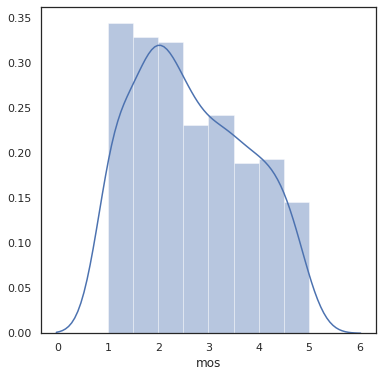

In [42]:
dratings = pd.read_csv("objective_metrics_and_mos_ci.csv")
d(dratings.head())
ax = sns.distplot(dratings["mos"])

plot(ax, "mos_dist")

checkout correlations of all objective metrics with subjective scores

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


['adm2', 'ms_ssim', 'psnr', 'ssim', 'vif_scale0', 'vif_scale1', 'vif_scale2', 'vif_scale3', 'vmaf']


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

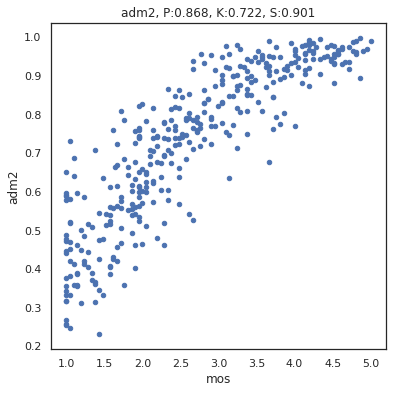

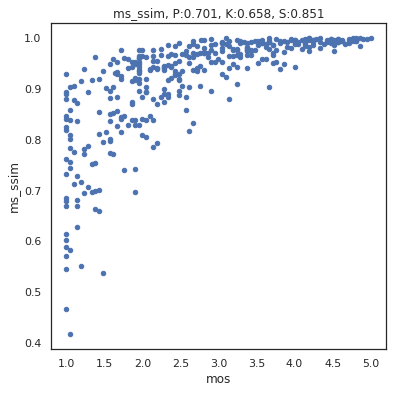

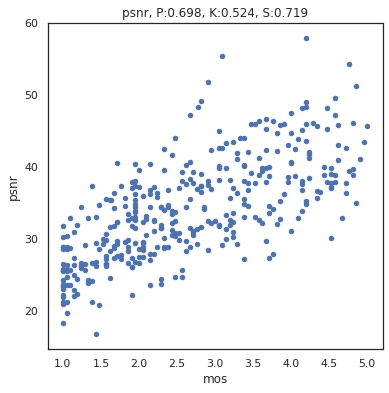

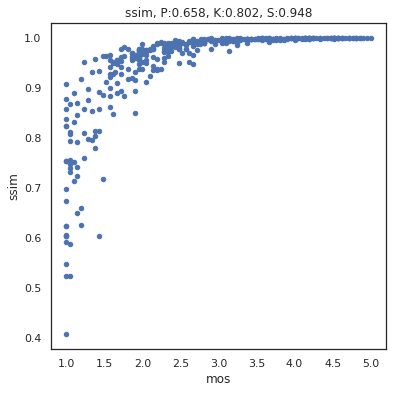

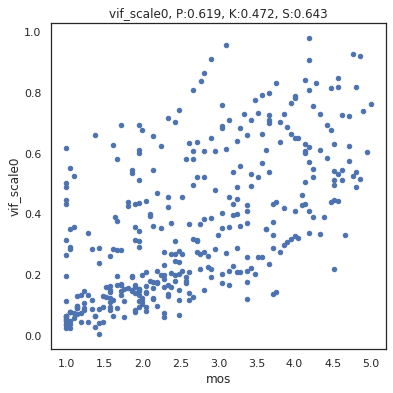

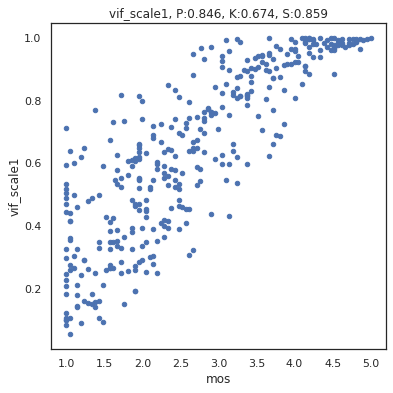

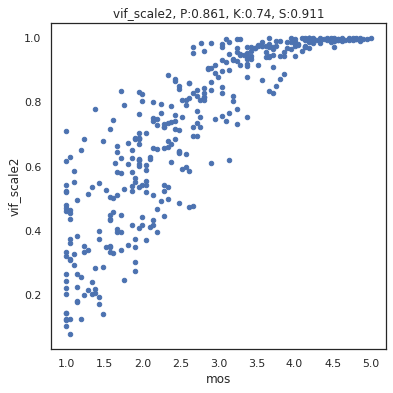

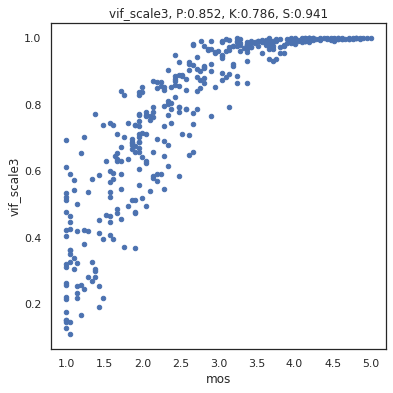

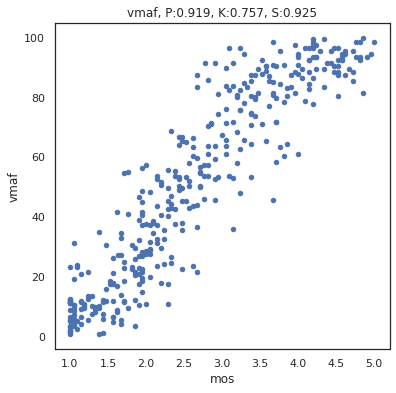

In [9]:
metrics = list(do.columns.difference(["image"]))
print(metrics)

corr_values = []
for m in metrics:
    p = dm[["mos", m]].corr(method="pearson")["mos"][1]
    k = dm[["mos", m]].corr(method="kendall")["mos"][1]
    s = dm[["mos", m]].corr(method="spearman")["mos"][1]
    title =f"{m}, P:{p.round(3)}, K:{k.round(3)}, S:{s.round(3)}"
    ax = dm[["mos", m]].plot(x="mos", y=m, kind="scatter", figsize=(6,6), title=title)
    plot(ax, f"corr_{m}")
    corr_values.append({
        "metric": m,
        "pearson": p,
        "kendall": k,
        "spearman": s
    }
    )
    
dcorr = pd.DataFrame(corr_values)
dcorr.to_csv("correlations.csv", index=False)

In [46]:
table = dcorr.sort_values(by="pearson", ascending=False).round(3)
d(table)

table.to_latex("objective_metrics_images.tex", index=False)

,metric,pearson,kendall,spearman
8,vmaf,0.919,0.757,0.925
0,adm2,0.868,0.722,0.901
6,vif_scale2,0.861,0.740,0.911
7,vif_scale3,0.852,0.786,0.941
5,vif_scale1,0.846,0.674,0.859
1,ms_ssim,0.701,0.658,0.851
2,psnr,0.698,0.524,0.719
3,ssim,0.658,0.802,0.948
4,vif_scale0,0.619,0.472,0.643


vmaf correlation is the best, followed by adm2 (that is mainly used for vmaf in case of static videos)

here no linear or cubic or logistic mapping is performed, because it is hard to be done with one test